# Practical 6 - Detecting points of interest

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import itertools
from scipy.ndimage.interpolation import shift

path_base =  '/content/drive/MyDrive/Colab Notebooks/M1_DSAI_IAwAtSI_PW1/Base_images'
# source des équations : https://courses.cs.washington.edu/courses/cse576/06sp/notes/HarrisDetector.pdf

<ipython-input-4-e8b09cbf55dd>:5: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


# 1- Harris detector - getting started

In an image, certain points stand out by their intensity relative to their surroundings, indicating a sudden variation in gray level intensity and/or a change in the orientation of a curve (inflection point or corner). A number of interest point detectors are available. Here, we propose to implement the Harris detector. This considers the differences (squared) in intensity around a point for all points in the image.


1. Create a 150x150 image featuring a black square on a white background (chessboard) and save it as a checkboard.


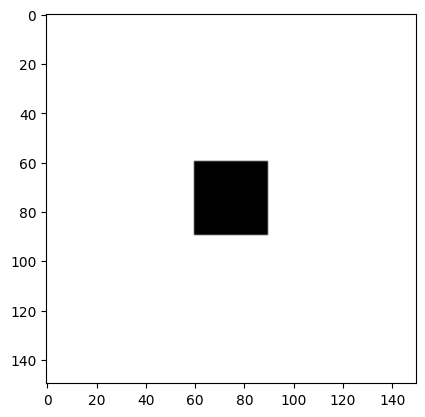

In [21]:
## It's up to you now :)
image_size = 150
square_size = 30
checkboard = np.ones((image_size, image_size), dtype=np.uint8) * 255  # White background

# Define the position of the black square
start_x = (image_size - square_size) // 2
end_x = start_x + square_size
start_y = (image_size - square_size) // 2
end_y = start_y + square_size

# Draw the black square in the center
checkboard[start_x:end_x, start_y:end_y] = 0

plt.imshow(checkboard, cmap='gray')
plt.show()

# 2- Harris algorithm

Harris' principle is to calculate intensity changes in the image in all directions. This results in the calculation of the E energy in three situations

- Situation 1: Intensity is approximately constant in the image area under consideration: the E function will then take small values in all directions (x,y).
- Situation 2: The image area under consideration contains a rectilinear contour: the E function will then take low values for displacements (x,y) along the contour and high values for displacements perpendicular to the contour.
- Situation 3: The image area under consideration contains a corner or an isolated point (point of interest): the E function will take strong values in all directions.

Calculating values in different directions is naturally done by calculating the directional derivatives at each pixel.

2. Calculate the Ix and Iy derivatives of the image


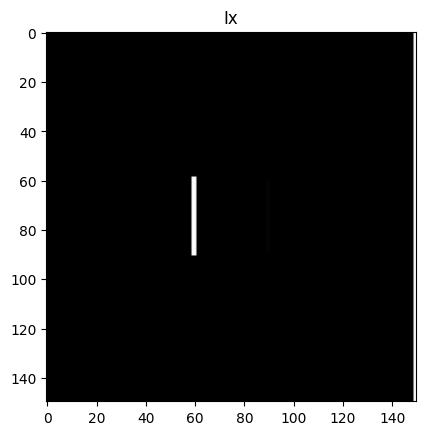

In [22]:
# Sobel operator kernels for x and y directions
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1],
                    [ 0,  0,  0],
                    [ 1,  2,  1]])

# Function to perform convolution
def convolve2d(image, kernel):
    """
    Perform 2D convolution manually.
    Args:
        image (numpy.ndarray): Input image
        kernel (numpy.ndarray): Kernel for convolution
    Returns:
        numpy.ndarray: Result of convolution
    """
    kernel = np.flipud(np.fliplr(kernel))  # Flip kernel for convolution
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    output = np.zeros_like(image)
    for i in range(image_h):
        for j in range(image_w):
            region = padded_image[i:i + kernel_h, j:j + kernel_w]
            output[i, j] = np.sum(region * kernel)
    return output

# Compute gradients Ix and Iy
Ix = convolve2d(checkboard, sobel_x)
Iy = convolve2d(checkboard, sobel_y)

plt.title('Ix')
plt.imshow(Ix, cmap='gray')
plt.show()

plt.title('Iy')
plt.imshow(Iy, cmap='gray')
plt.show()

3. Calculate (point by point)
\begin{equation*}
    a = (\frac{dI}{dx})^{2}
\end{equation*}

\begin{equation*}
    b = (\frac{dI}{dx})\dot(\frac{dI}{dy})
\end{equation*}


\begin{equation*}
    c = (\frac{dI}{dy})^{2}
\end{equation*}

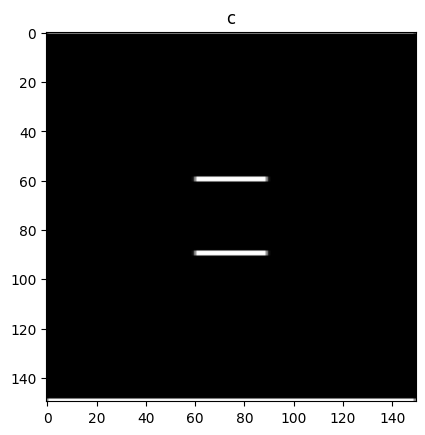

In [23]:
a = Ix**2  # (dI/dx)^2
b = Ix * Iy  # (dI/dx) * (dI/dy)
c = Iy**2  # (dI/dy)^2

plt.title('a')
plt.imshow(a, cmap='gray')
plt.show()

plt.title('b')
plt.imshow(b, cmap='gray')
plt.show()

plt.title('c')
plt.imshow(c, cmap='gray')
plt.show()

# Harris R operator
4. Calculate lambda 1 and lambda 2, the principal axes of the E ellipse for each pixel.


In [26]:
# Function to calculate eigenvalues λ1 and λ2
def calculate_eigenvalues(a, b, c):
    """
    Calculate the eigenvalues (λ1, λ2) for each pixel.
    Args:
        a (numpy.ndarray): Matrix a = (dI/dx)^2
        b (numpy.ndarray): Matrix b = (dI/dx)(dI/dy)
        c (numpy.ndarray): Matrix c = (dI/dy)^2
    Returns:
        lambda1, lambda2 (numpy.ndarray, numpy.ndarray): Eigenvalues for each pixel
    """
    trace = a + c
    determinant = (a * c) - (b * b)
    sqrt_term = np.sqrt(np.maximum(trace**2 - 4 * determinant, 0))  # Ensure no negative values under sqrt

    lambda1 = (trace + sqrt_term) / 2
    lambda2 = (trace - sqrt_term) / 2

    return lambda1, lambda2

# Compute the eigenvalues
lambda1, lambda2 = calculate_eigenvalues(a, b, c)

5. Show images lamda 1 and lamda 2. What do you think?

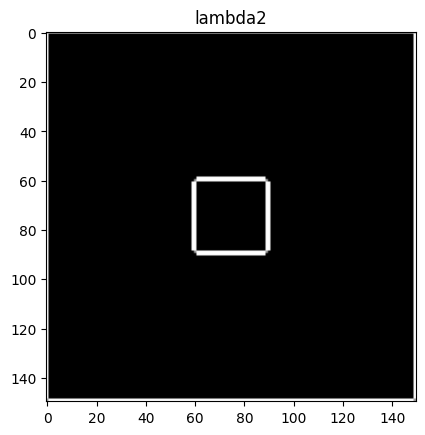

In [27]:
plt.title('lambda1')
plt.imshow(lambda1, cmap='gray')
plt.show()

plt.title('lambda2')
plt.imshow(lambda2, cmap='gray')
plt.show()

6. Calculate the Harris operator R with 0.04 < k <0.06

In [31]:
# Function to calculate the Harris response (R)
def calculate_harris_response(a, b, c, k=0.04):
    """
    Calculate the Harris response (R) for each pixel.
    Args:
        a (numpy.ndarray): Matrix a = (dI/dx)^2
        b (numpy.ndarray): Matrix b = (dI/dx)(dI/dy)
        c (numpy.ndarray): Matrix c = (dI/dy)^2
        k (float): Harris detector constant (typically between 0.04 and 0.06)
    Returns:
        numpy.ndarray: Harris response (R)
    """
    determinant = (a * c) - (b * b)
    trace = a + c
    R = determinant - k * (trace ** 2)
    return R

# Calculate Harris response with k = 0.04
k = 0.04
R = calculate_harris_response(a, b, c, k)

7. Display image R

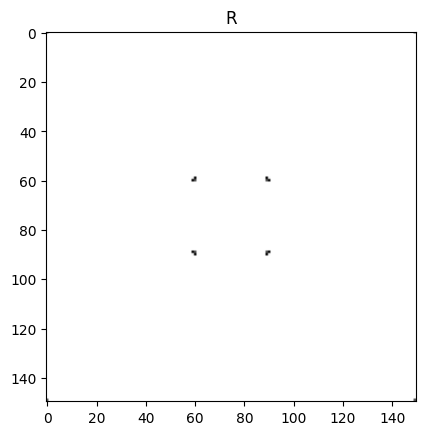

In [32]:
plt.title('R')
plt.imshow(R, cmap='gray')
plt.show()

8. Creez une fonction qui prend en entrée l'image originale et donne en sortie l'image R = Harris_Oprator(img)

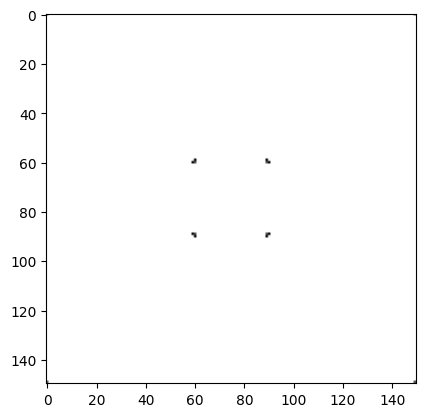

In [40]:
def Harris_Operator(img):
  Ix = convolve2d(img, sobel_x)
  Iy = convolve2d(img, sobel_y)
  a = Ix**2
  b = Ix * Iy
  c = Iy**2
  R = calculate_harris_response(a, b, c)
  return R

plt.imshow(Harris_Operator(checkboard), cmap='gray')
plt.show()

# 3- Detecting points of interest

Points of interest are pixels for which R>0 (R<0: contour, abs(R) very small: homogeneous zone).

9. Choose the threshold t of your choice on the R image to detect the most salient points of interest.

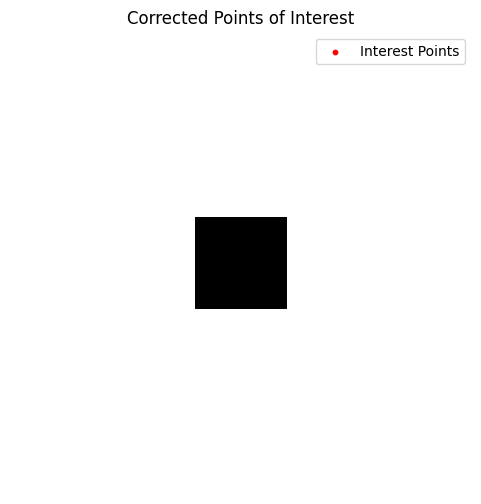

In [55]:
# Redefine the detection function with an adjusted thresholding approach
def detect_points_of_interest(R, threshold=0.1):
    """
    Detect points of interest based on the Harris response (R).

    Args:
        R (numpy.ndarray): Harris response matrix
        threshold (float): Threshold as a proportion of the max R value

    Returns:
        list of tuple: List of (row, col) coordinates of interest points
    """
    # Use absolute threshold based on the max R value
    threshold_value = threshold * np.max(R)

    # Detect points where R exceeds the threshold
    interest_points = np.argwhere(R > threshold_value)

    return interest_points

# Adjust the threshold to a more appropriate value
interest_points_corrected = detect_points_of_interest(R, threshold=1000)

# Display the points of interest on the original image
plt.figure(figsize=(6, 6))
plt.title("Corrected Points of Interest")
plt.imshow(checkboard, cmap='gray')
plt.scatter(
    interest_points_corrected[:, 1],
    interest_points_corrected[:, 0],
    color='red',
    s=10,
    label='Interest Points'
)
plt.legend(loc='upper right')
plt.axis('off')
plt.show()

10. Correct your function to have another function Harris_Corner_Detector(img, N) which outputs the points of interest directly on the img image, where N is the number of points of interest to be detected.

In [39]:
def Harris_Corner_Detector(img, N):
  R = Harris_Operator(img)
  points = detect_points_of_interest(R, np.sort(R.flatten())[-N])
  plt.imshow(img, cmap='gray')
  plt.scatter(points[:, 1], points[:, 0], s=10, c='red', marker='x')
  plt.title(f'{N} Points of Interest')
  plt.show()
  return points

Harris_Corner_Detector(checkboard, 5)

array([], shape=(0, 2), dtype=int64)

# 3 - Application
11. Apply your function to the image lena_gray.tif with 50 points of interest detected


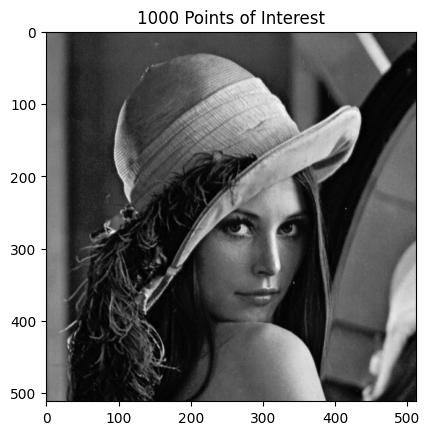

array([], shape=(0, 2), dtype=int64)

In [36]:
img = cv2.imread(path_base+'/lena_gray.tif',-1)
Harris_Corner_Detector(img, 1000)

12. Repeat the same process, filtering A, B and C with a 5x5 Gaussian filter. Is the detection result improved?

In [37]:
def apply_gaussian_filter(img, kernel_size=(5, 5)):
  blurred_img = cv2.GaussianBlur(img, kernel_size, 0)
  return blurred_img

filtered_img = apply_gaussian_filter(img)

Harris_Corner_Detector(filtered_img, 1000)

array([], shape=(0, 2), dtype=int64)

# Bonus
13. Incorporate the NMS into your function: a 7x7 filter that slides over the R image to select the pixel with the maximum value.